# **LOADING THE DATASET**

> Here I will load my dataset and access some properties, like the shape, certain columns, duplicates, null values, redundant columns, e.t.c.



In [87]:
import pandas as pd

In [88]:
df = pd.read_csv("behaviour_simulation_train.xlsx - Sheet1.csv")

In [89]:
df.isnull().sum()

,0
id,0
date,0
likes,0
content,0
username,0
media,0
inferred company,0


In [90]:
df.duplicated().sum()

np.int64(0)

In [91]:
df.dtypes

,0
id,int64
date,object
likes,int64
content,object
username,object
media,object
inferred company,object


In [92]:
df.shape

(17331, 7)

In [93]:
df

,id,date,likes,content,username,media,inferred company
0,1,2020-12-12 00:47:00,1,"Spend your weekend morning with a Ham, Egg, an...",TimHortonsPH,[Photo(previewUrl='https://pbs.twimg.com/media...,tim hortons
1,2,2018-06-30 10:04:20,2750,Watch rapper <mention> freestyle for over an H...,IndyMusic,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
2,3,2020-09-29 19:47:28,57,Canadian Armenian community demands ban on mil...,CBCCanada,[Photo(previewUrl='https://pbs.twimg.com/media...,cbc
3,4,2020-10-01 11:40:09,152,"1st in Europe to be devastated by COVID-19, It...",MKWilliamsRome,[Photo(previewUrl='https://pbs.twimg.com/media...,williams
4,5,2018-10-19 14:30:46,41,Congratulations to Pauletha Butts of <mention>...,BGISD,[Photo(previewUrl='https://pbs.twimg.com/media...,independent
...,...,...,...,...,...,...,...
17326,17327,2020-12-12 03:15:00,56,"After 66 years together, this couple died of #...",cbcnewsbc,[Video(thumbnailUrl='https://pbs.twimg.com/amp...,cbc
17327,17328,2018-02-09 21:47:11,2,Where to add wireless measurements &amp;amp; a...,EMR_Automation,[Photo(previewUrl='https://pbs.twimg.com/media...,emerson
17328,17329,2018-05-03 14:26:09,181,This is what happened outside a Bromley pollin...,Independent,[Video(thumbnailUrl='https://pbs.twimg.com/ext...,independent
17329,17330,2020-01-27 11:52:03,0,Int’l Day Of Education: CSO Sensitises Childre...,IndependentNGR,[Photo(previewUrl='https://pbs.twimg.com/media...,independent


In [94]:
for column in df.columns:
  print(column)

id
date
likes
content
username
media
inferred company


In [95]:
for col in df.columns:
  print(f"Column '{col}': {df[col].nunique()} unique values")

Column 'id': 17331 unique values
Column 'date': 17292 unique values
Column 'likes': 2589 unique values
Column 'content': 17126 unique values
Column 'username': 1325 unique values
Column 'media': 17307 unique values
Column 'inferred company': 194 unique values


In [96]:
df.describe()

,id,likes
count,17331.000000,17331.000000
mean,8666.000000,718.392130
std,5003.173093,3866.475948
min,1.000000,0.000000
25%,4333.500000,3.000000
50%,8666.000000,73.000000
75%,12998.500000,352.000000
max,17331.000000,254931.000000


# **LIGHT PREPROCESSING (FOR EDA AND DEV READINESS)**

> I will clean my dataset, of redundant columns, change the format of the date column to DateTime format and extract some features, and I will add some more features to the data frame which will help us in exploratory data analysis.



In [97]:
df['has_media'] = df['media'].apply(lambda x: x != 'no_media')
df['content'] = df['content'].astype(str).str.strip().str.lower()
df['datetime'] = pd.to_datetime(df['date'], errors='coerce')

In [98]:
df.drop(columns=['date', 'media'], inplace=True)

In [99]:
df = df.rename(columns={'id': 'Id', 'likes': 'Likes', 'content': 'Content', 'username': 'Username', 'inferred company': 'Inferred Company', 'datetime': 'Release Time', 'has_media': 'Has media'})

In [100]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Inferred Company Encoded'] = label_encoder.fit_transform(df['Inferred Company'])

In [101]:
from datetime import time
df['Release Time_year'] = df['Release Time'].dt.year
df['Release Time_month'] = df['Release Time'].dt.month
df['Release Time_day'] = df['Release Time'].dt.day
df['Release Time_hour'] = df['Release Time'].dt.hour
df['Release Time_minute'] = df['Release Time'].dt.minute
df['Release Time_second'] = df['Release Time'].dt.second
df['Release Time_time_of_day'] = df.apply(lambda row: time(row['Release Time_hour'], row['Release Time_minute'], row['Release Time_second']), axis=1)
df.drop(columns = "Release Time", inplace = True)

In [102]:
df['has_mention'] = df['Content'].str.contains('<mention>')
is_id_sequential = (df['Id'] == df.index + 1).all()
print(f"Is the 'Id' column equal to index + 1? {is_id_sequential}")

Is the 'Id' column equal to index + 1? True


In [103]:
df['content_length'] = df['Content'].str.len()
df['word_count'] = df['Content'].str.split().str.len()
user_agg_data = df.groupby('Username')['Likes'].agg(['count', 'sum']).reset_index()
user_agg_data.columns = ['Username', 'user_post_count', 'total_likes']
user_agg_data['average_likes_post'] = user_agg_data['total_likes'] / user_agg_data['user_post_count']
df = df.merge(user_agg_data[['Username', 'user_post_count', 'average_likes_post']], on='Username', how='left')
df['is_weekend'] = pd.to_datetime({'year': df['Release Time_year'],
                                   'month': df['Release Time_month'],
                                   'day': df['Release Time_day'],
                                   'hour': df['Release Time_hour'],
                                   'minute': df['Release Time_minute'],
                                   'second': df['Release Time_second']}).dt.dayofweek >= 5
df.drop(columns = ['Release Time_minute', 'Release Time_hour', 'Release Time_second', 'Inferred Company'], inplace = True)
new_column_order = ['Username', 'user_post_count', 'average_likes_post', 'Content', 'word_count', 'content_length', 'Has media', 'has_mention', 'Release Time_year', 'Release Time_month', 'Release Time_day', 'Release Time_time_of_day', 'is_weekend', 'Inferred Company Encoded', 'Likes']
df = df[new_column_order]
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17331 entries, 0 to 17330
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   username                  17331 non-null  object 
 1   user_post_count           17331 non-null  int64  
 2   average_likes_post        17331 non-null  float64
 3   content                   17331 non-null  object 
 4   word_count                17331 non-null  int64  
 5   content_length            17331 non-null  int64  
 6   has_media                 17331 non-null  bool   
 7   has_mention               17331 non-null  bool   
 8   release_time_year         17331 non-null  int32  
 9   release_time_month        17331 non-null  int32  
 10  release_time_day          17331 non-null  int32  
 11  release_time_time_of_day  17331 non-null  object 
 12  is_weekend                17331 non-null  bool   
 13  inferred_company_encoded  17331 non-null  int64  
 14  likes 

In [105]:
df.describe()

,user_post_count,average_likes_post,word_count,content_length,release_time_year,release_time_month,release_time_day,inferred_company_encoded,likes
count,17331.00000,17331.000000,17331.000000,17331.000000,17331.000000,17331.000000,17331.000000,17331.000000,17331.000000
mean,310.11315,718.392130,22.501356,147.868617,2019.085108,6.522647,15.682534,83.462235,718.392130
std,597.97351,2151.111797,11.842720,71.690684,0.816360,3.462951,8.777625,54.537641,3866.475948
min,1.00000,0.000000,2.000000,20.000000,2018.000000,1.000000,1.000000,0.000000,0.000000
25%,16.00000,3.604651,12.000000,88.000000,2018.000000,3.000000,8.000000,38.000000,3.000000
50%,49.00000,161.631579,21.000000,136.000000,2019.000000,7.000000,16.000000,87.000000,73.000000
75%,162.00000,603.562500,31.000000,202.000000,2020.000000,10.000000,23.000000,120.000000,352.000000
max,1927.00000,71375.500000,63.000000,323.000000,2020.000000,12.000000,31.000000,193.000000,254931.000000


In [106]:
df.to_excel('Cleaned_Dataset.xlsx', index=False)

# **EXPLORATORY DATA ANALYSIS**

> Here I will explore the dataset, by plotting some bar graphs, histograms, line charts and more, to compare the number of likes to the features in my data

<Axes: xlabel='likes', ylabel='Count'>

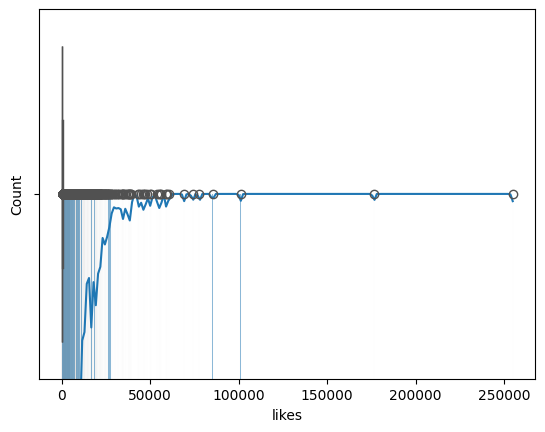

In [107]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(df['likes'], kde=True)
sns.boxplot(x=df['likes'])

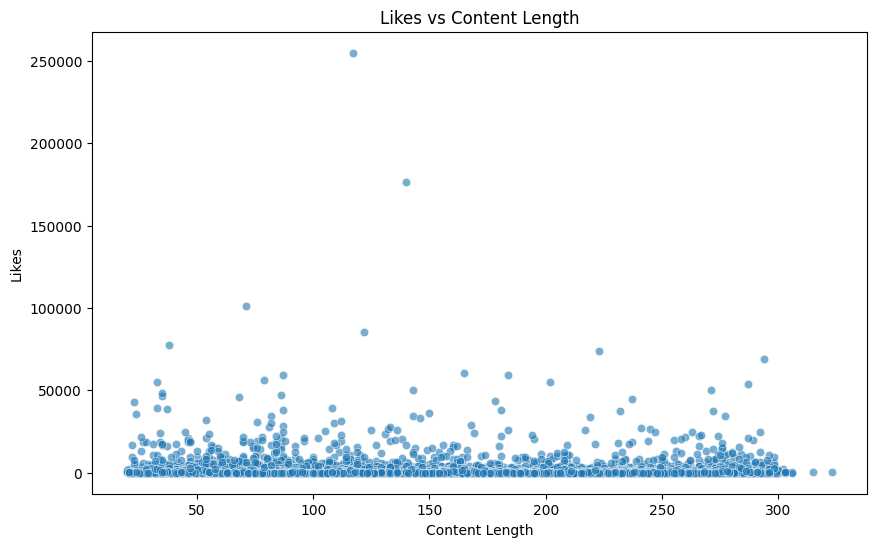

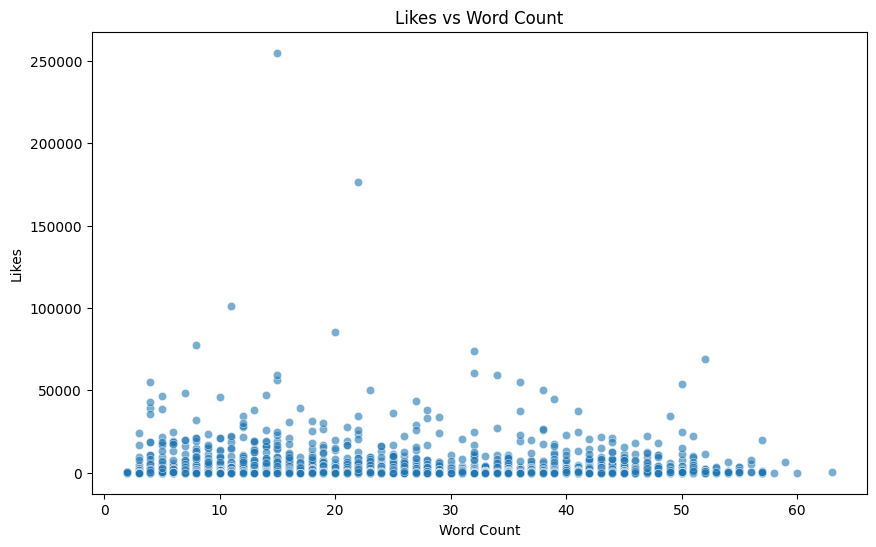

In [108]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='content_length', y='likes', data=df, alpha=0.6)
plt.title('Likes vs Content Length')
plt.xlabel('Content Length')
plt.ylabel('Likes')
plt.show()
plt.figure(figsize=(10, 6))
sns.scatterplot(x='word_count', y='likes', data=df, alpha=0.6)
plt.title('Likes vs Word Count')
plt.xlabel('Word Count')
plt.ylabel('Likes')
plt.show()

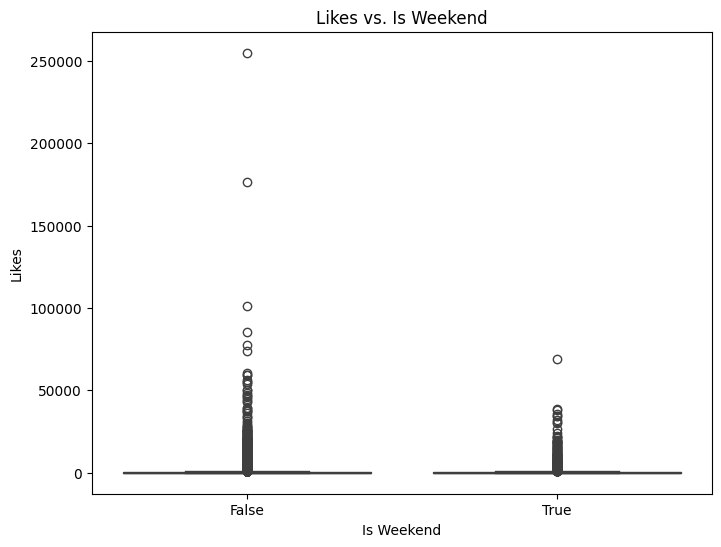

In [109]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='is_weekend', y='likes', data=df)
plt.title('Likes vs. Is Weekend')
plt.xlabel('Is Weekend')
plt.ylabel('Likes')
plt.show()

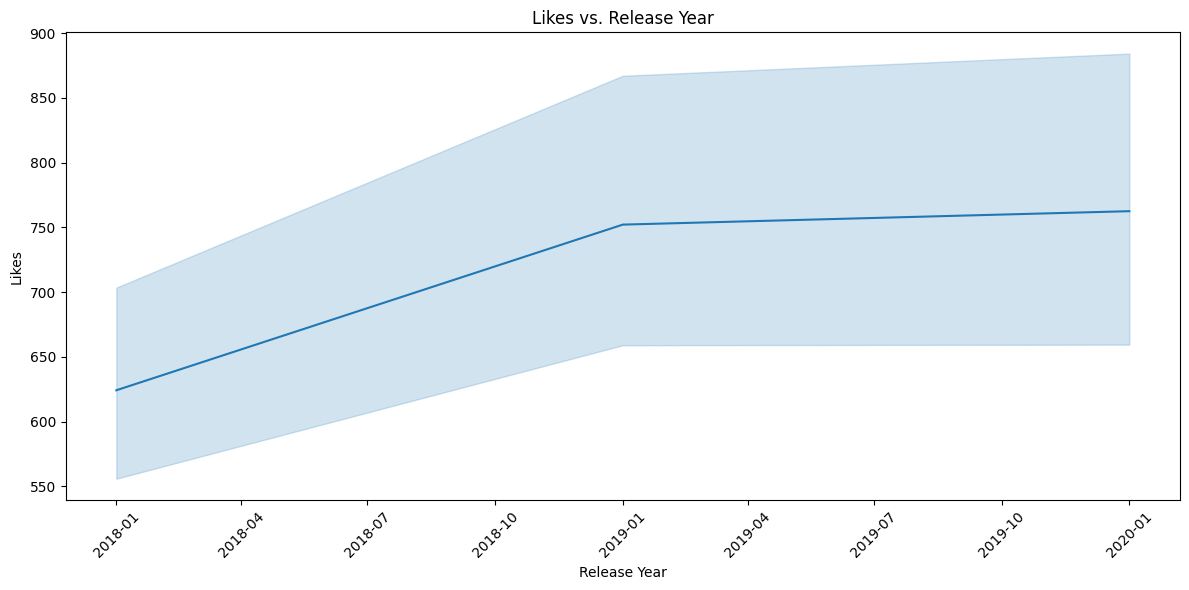

In [110]:
df['release_year_date'] = pd.to_datetime(df['release_time_year'].astype(str) + '-01-01')
plt.figure(figsize=(12, 6))
sns.lineplot(x='release_year_date', y='likes', data=df)
plt.title('Likes vs. Release Year')
plt.xlabel('Release Year')
plt.ylabel('Likes')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
df.drop(columns = "release_year_date",inplace = True)

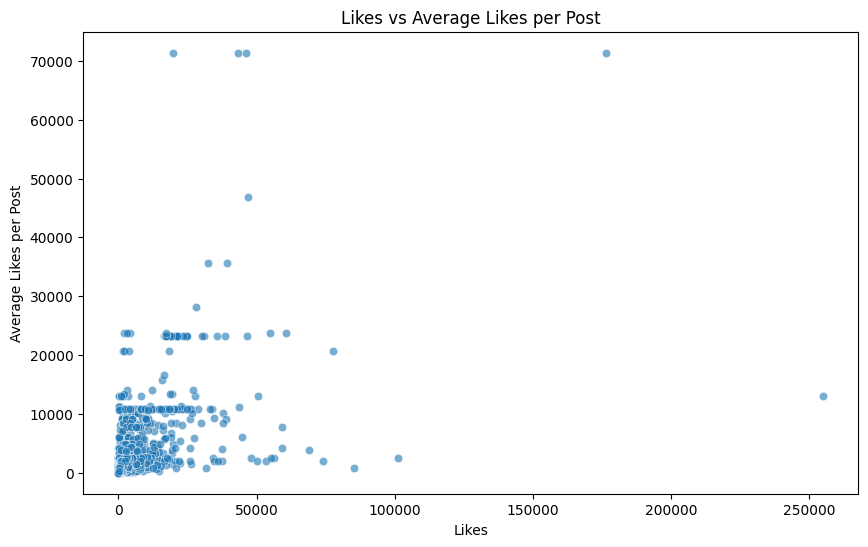

In [111]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='likes', y='average_likes_post', data=df, alpha=0.6)
plt.title('Likes vs Average Likes per Post')
plt.xlabel('Likes')
plt.ylabel('Average Likes per Post')
plt.show()

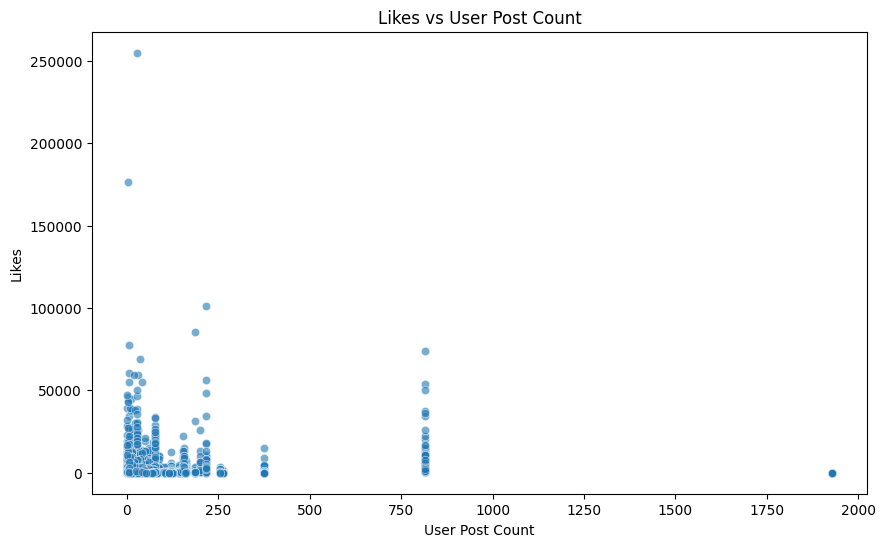

In [112]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='user_post_count', y='likes', data=df, alpha=0.6)
plt.title('Likes vs User Post Count')
plt.xlabel('User Post Count')
plt.ylabel('Likes')
plt.show()

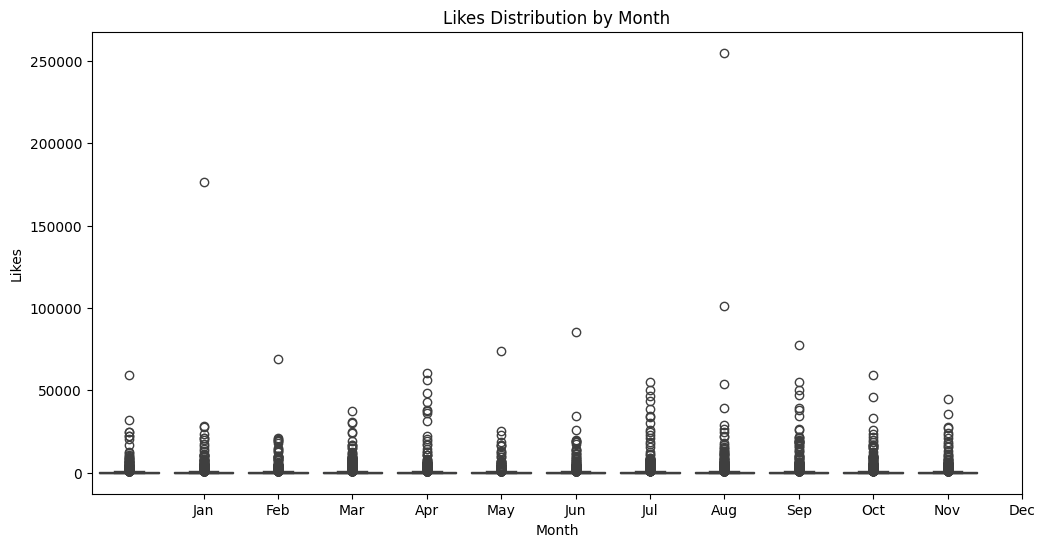

In [113]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='release_time_month', y='likes', data=df)
plt.title('Likes Distribution by Month')
plt.xlabel('Month')
plt.ylabel('Likes')
plt.xticks(range(1, 13), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
plt.show()

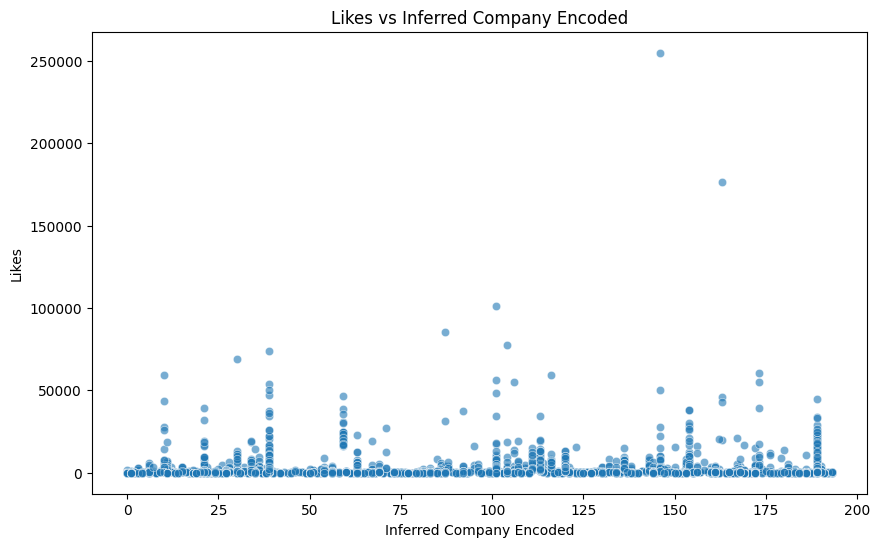

In [114]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='inferred_company_encoded', y='likes', data=df, alpha=0.6)
plt.title('Likes vs Inferred Company Encoded')
plt.xlabel('Inferred Company Encoded')
plt.ylabel('Likes')
plt.show()

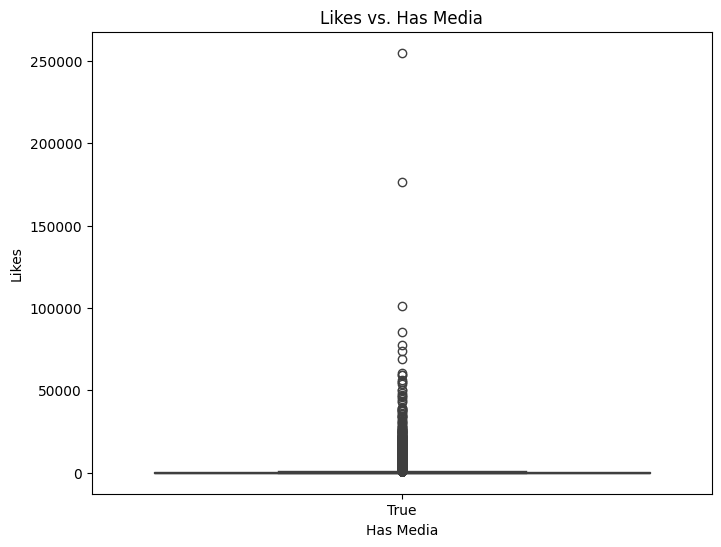

In [115]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='has_media', y='likes', data=df)
plt.title('Likes vs. Has Media')
plt.xlabel('Has Media')
plt.ylabel('Likes')
plt.show()

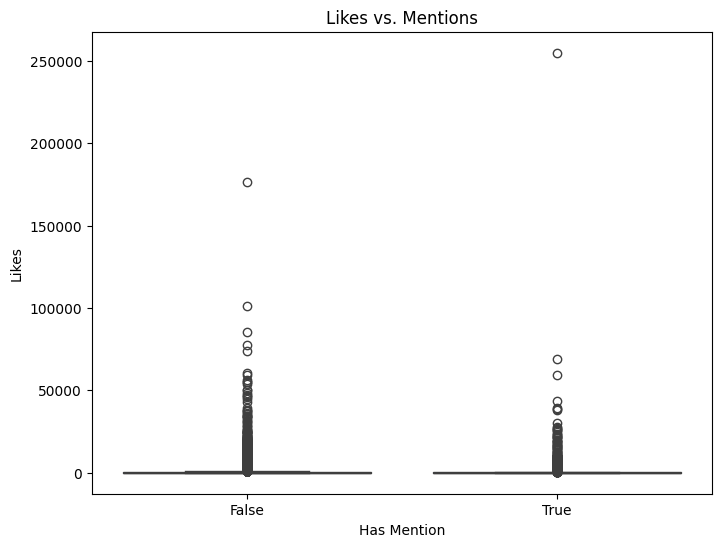

In [116]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='has_mention', y='likes', data=df)
plt.title('Likes vs. Mentions')
plt.xlabel('Has Mention')
plt.ylabel('Likes')
plt.show()